Find the optimal number of hidden neurons for the first depth and widths of the neural network designed in Question 1 and 2.

#### Plot the mean cross-validation accuracies on the final epoch for at least 8 different combinations of different depth (limit to 1-3 layers) and widths (limit to 64, 128 or 256 neurons) using a scatter plot. Continue using 5-fold cross validation on the training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot. 

[optional + 2 marks] Implement an alternative approach that searches through these combinations that could significantly reduce the computational time but achieve similar search results, without enumeration all the possibilities.



This might take a while to run, approximately 30 - 60 min, so plan your time carefully.

1.Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2.To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import split_dataset, preprocess_dataset

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()

X_train, y_train, X_test, y_test = split_dataset(df, ["filename", "label"], 0.2, 0)

In [3]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float).unsqueeze(1)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

3.Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [4]:
no_features = 77
no_labels = 1
no_folds = 5

optimal_bs = 64 #Obtained from part A_2
patience = 3
lr = 0.001
epochs = 100

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    train_loss, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += torch.sum(torch.eq(pred > 0.5, y.clone().detach()))

    train_loss /= num_batches
    train_correct = train_correct.float() /size  

    return train_loss, train_correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, test_correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += torch.sum(torch.eq(pred > 0.5, y.clone().detach()))
        test_loss /= num_batches
        test_correct = test_correct.float()/size

    return test_loss, test_correct

In [6]:
from common_utils import EarlyStopper

def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
    train_data = CustomDataset(X_train_scaled, y_train2)
    val_data = CustomDataset(X_val_scaled, y_val2)
    
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    loss_fn = nn.BCELoss()
    early_stopper = EarlyStopper(patience=patience, min_delta=0)

    for t in range(epochs):
        start_time = time.time()

        train_losses, train_accuracies = train_loop(train_dataloader, model,loss_fn, optimizer)
        test_losses, test_accuracies = test_loop(val_dataloader, model, loss_fn)
        print(f"Epoch {t+1}: Train_accuracy: {(100*train_accuracies):>0.2f}%, Train_loss: {train_losses:>8f}, Val_accuracy: {(100*test_accuracies):>0.2f}%, val_loss: {test_losses:>8f}")

        if early_stopper.early_stop(test_losses):
            end_time = time.time() - start_time
            break

    return train_accuracies, train_losses, test_accuracies, test_losses, end_time

In [7]:
#Redefine Model that can take on these combinations as arguments
class MLP_Custom(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        layers = []

        #First Layer
        layers.append(nn.Linear(no_features, no_hidden[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(p=0.2))

        for i in range(1, len(no_hidden)):
            layers.append(nn.Linear(no_hidden[i-1], no_hidden[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=0.2))
        
        #Final Layer
        layers.append(nn.Linear(no_hidden[-1], no_labels))
        layers.append(nn.Sigmoid()) 

        self.mlp_stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits

In [8]:
import itertools
from sklearn.preprocessing import StandardScaler

def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):
    cross_validation_accuracies  = {}  
    cross_validation_times = {}
    cv_loss = {}
    
    for no_hidden in parameters:
        print(f'--------------------- {mode}: {no_hidden} ---------------------')

        acc = []
        time = []
        losses = []

        split = KFold(n_splits=5, shuffle=True, random_state=42)
        
        for fold, (train_idx, val_idx) in enumerate(split.split(X_train, y_train)):
            X_train_fold, y_train2 = X_train[train_idx], y_train[train_idx]
            X_val_fold, y_val2 = X_train[val_idx], y_train[val_idx]

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_fold)
            X_val_scaled = scaler.transform(X_val_fold)

            print(f'------ Fold: {fold + 1} ------')
            model = MLP_Custom(no_features, no_hidden, no_labels)
        
            train_accuracies, train_losses, test_accuracies, test_losses, times = train(model,X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size)
            
            time.append(times) 
            acc.append(test_accuracies)  
            losses.append(test_losses) 
            
            print(f"Combination: {no_hidden}, Fold {fold + 1}, Final validation loss: {test_losses:.4f} and validation accuracy: {test_accuracies:.4f}")
            
        cross_validation_accuracies[no_hidden] = np.mean(acc)
        cross_validation_times[no_hidden] = np.mean(time)
        cv_loss[no_hidden] = np.mean(losses)

    return cross_validation_accuracies, cross_validation_times

'''
optimal_bs = 0. Fill your optimal batch size in the following code.
'''

#Finding all different combination, of depth limit 3, and 54, 128 and 256 neurons
values = [64, 128, 256, None]  # Using None for "empty" slots
combinations = list(itertools.product(values, repeat=3))
combinations = [combo for combo in combinations if combo != (None, None, None)]
combinations = [tuple(filter(lambda x: x is not None, combo)) for combo in combinations]
combinations = list(set(combinations))

print(f"Total number of combinations: {len(combinations)}")
print(f"Combinations: {combinations}")
print()

optimal_bs = 64 #Obtained from part A_2
num_neurons = [(128, 256, 256), (256, 64, 64), (256, 128, 128), (256, 64, 128), (256, 128, 256), (256, 64, 256), (128, 128, 64), (128, 128, 128), (128, 64, 64), (128, 64, 128), (128, 128, 256), (128, 64, 256), (64, 256, 64), (64, 256, 128), (64, 256, 256), (256, 64), (256, 128), (64, 128, 64), (64, 128, 128), (256, 256), (64, 128, 256), (64, 64, 64), (64, 64, 128), (128, 64), (64, 64), (64, 64, 256), (128, 128), (64, 128), (64,), (128, 256), (64, 256), (128,), (256, 256, 64), (256, 256, 128), (256,), (256, 256, 256), (128, 256, 64), (128, 256, 128), (256, 128, 64)]
cross_validation_accuracies, cross_validation_times =find_optimal_hyperparameter(X_train.to_numpy(), y_train, num_neurons, 'num_neurons', optimal_bs)

Total number of combinations: 39
Combinations: [(128, 256, 256), (256, 64, 64), (256, 128, 128), (256, 64, 128), (256, 128, 256), (256, 64, 256), (128, 128, 64), (128, 128, 128), (128, 64, 64), (128, 64, 128), (128, 128, 256), (128, 64, 256), (64, 256, 64), (64, 256, 128), (64, 256, 256), (256, 64), (256, 128), (64, 128, 64), (64, 128, 128), (256, 256), (64, 128, 256), (64, 64, 64), (64, 64, 128), (128, 64), (64, 64), (64, 64, 256), (128, 128), (64, 128), (64,), (128, 256), (64, 256), (128,), (256, 256, 64), (256, 256, 128), (256,), (256, 256, 256), (128, 256, 64), (128, 256, 128), (256, 128, 64)]

--------------------- num_neurons: (128, 256, 256) ---------------------
------ Fold: 1 ------
Epoch 1: Train_accuracy: 56.42%, Train_loss: 0.683983, Val_accuracy: 57.02%, val_loss: 0.674937
Epoch 2: Train_accuracy: 59.75%, Train_loss: 0.663718, Val_accuracy: 58.58%, val_loss: 0.676420
Epoch 3: Train_accuracy: 62.60%, Train_loss: 0.645827, Val_accuracy: 62.57%, val_loss: 0.647409
Epoch 4: Tr

4. Plot the mean cross-validation accuracies on the final epoch for at least 8 different combinations of different depth (limit to 1-3 layers) and widths (limit to 64, 128 or 256 neurons) using a scatter plot. 

In [12]:
cross_validation_accuracies = {str(key): value for key, value in cross_validation_accuracies.items()}
cross_validation_times = {str(key): value for key, value in cross_validation_times.items()}

C:\Users\joann\AppData\Local\Temp\ipykernel_30344\138228173.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(sorted_accuracies.keys(), rotation=90)
C:\Users\joann\AppData\Local\Temp\ipykernel_30344\138228173.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(sorted_time.keys(), rotation=90)


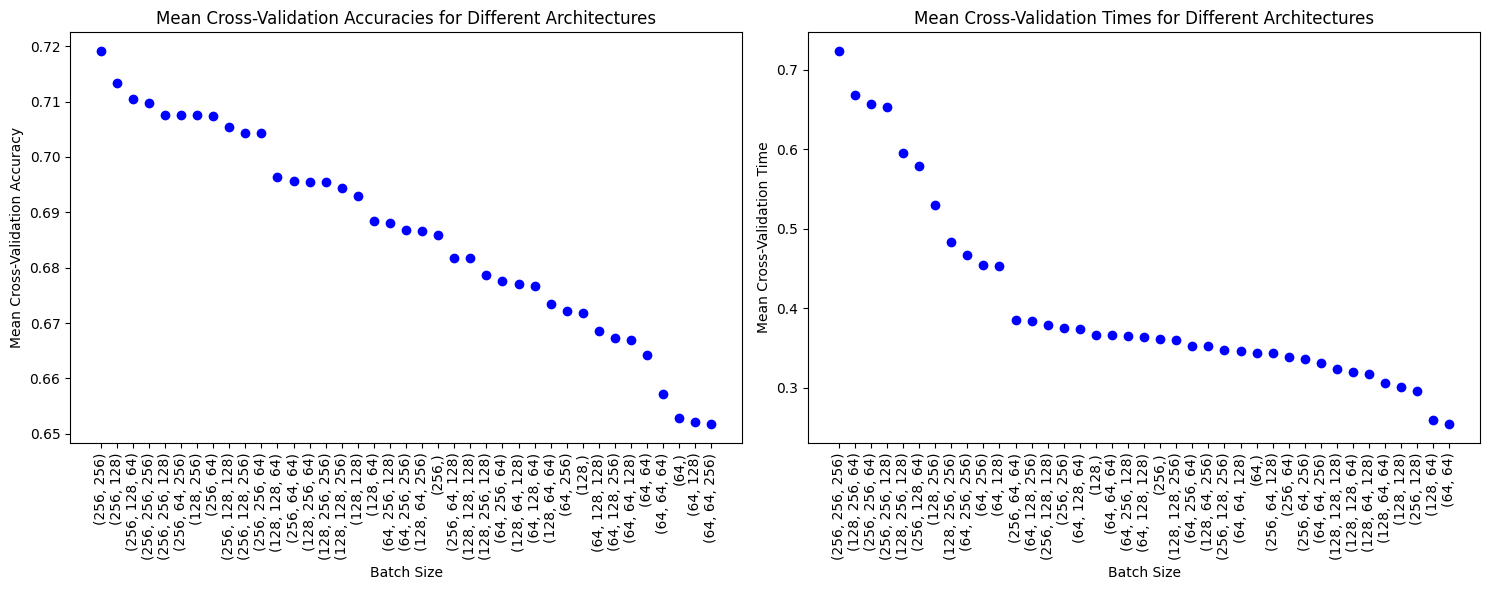

In [13]:
# Plotting the graphs side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot the mean cross-validation accuracy 
sorted_accuracies = dict(sorted(cross_validation_accuracies.items(), key=lambda item: item[1], reverse=True))
axs[0].scatter(sorted_accuracies.keys(), sorted_accuracies.values(), color='blue')
axs[0].set_title('Mean Cross-Validation Accuracies for Different Architectures')
axs[0].set_xlabel('Batch Size')
axs[0].set_xticklabels(sorted_accuracies.keys(), rotation=90)
axs[0].set_ylabel('Mean Cross-Validation Accuracy')

# Plot the mean cross-validation time 
sorted_time = dict(sorted(cross_validation_times.items(), key=lambda item: item[1], reverse=True))
axs[1].scatter(sorted_time.keys(), sorted_time.values(), color='blue')
axs[1].set_xticklabels(sorted_time.keys(), rotation=90)
axs[1].set_title('Mean Cross-Validation Times for Different Architectures')
axs[1].set_xlabel('Batch Size')
axs[1].set_ylabel('Mean Cross-Validation Time')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

5. Select the optimal combination for the depth and width. State the rationale for your selection.

In [16]:
optimal_combination = [256, 256]
reason = """
### Model Performance Summary

- **Top Performing Model:** `(256, 256)`  
- **Cross-validation Accuracy:** `72%`  
- **Computational Time:** `0.375` the 15th top computational time out of all the combinations

Thus, this choice **maximizes accuracy** while maintaining a balance with **computational efficiency**.
"""
# YOUR CODE HERE

### Model Performance Summary

- **Top Performing Model:** `(256, 256)`  
- **Cross-validation Accuracy:** `72%`  
- **Computational Time:** `0.375` the 15th top computational time out of all the combinations

Thus, this choice **maximizes accuracy** while maintaining a balance with **computational efficiency**.


6.Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.


In [17]:
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()

X_train, y_train, X_test, y_test = split_dataset(df, ["filename", "label"], 0.2, 0)

In [23]:
def train_return_full(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
    train_data = CustomDataset(X_train_scaled, y_train2)
    val_data = CustomDataset(X_val_scaled, y_val2)
    
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    loss_fn = nn.BCELoss()
    early_stopper = EarlyStopper(patience=patience, min_delta=0)

    train_accuracy_list = []
    test_accuracy_list = []
    train_loss_list = []
    test_loss_list = []
    for t in range(epochs):
        start_time = time.time()

        train_losses, train_accuracies = train_loop(train_dataloader, model,loss_fn, optimizer)
        test_losses, test_accuracies = test_loop(val_dataloader, model, loss_fn)
        print(f"Epoch {t+1}: Train_accuracy: {(100*train_accuracies):>0.2f}%, Train_loss: {train_losses:>8f}, Val_accuracy: {(100*test_accuracies):>0.2f}%, val_loss: {test_losses:>8f}")

        train_accuracy_list.append(train_accuracies)
        test_accuracy_list.append(test_accuracies)
        train_loss_list.append(train_losses)
        test_loss_list.append(test_losses)

        if early_stopper.early_stop(test_losses):
            end_time = time.time() - start_time
            break

    return train_accuracy_list, test_accuracy_list, train_loss_list, test_loss_list

In [24]:
optimal_model = MLP_Custom(no_features, (256,256), no_labels)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_accuracy_list, test_accuracy_list, train_loss_list, test_loss_list = train_return_full(optimal_model,X_train_scaled, y_train, X_test_scaled, y_test, optimal_bs)

Epoch 1: Train_accuracy: 57.17%, Train_loss: 0.676004, Val_accuracy: 58.87%, val_loss: 0.668666
Epoch 2: Train_accuracy: 61.50%, Train_loss: 0.651246, Val_accuracy: 61.11%, val_loss: 0.648850
Epoch 3: Train_accuracy: 64.51%, Train_loss: 0.627523, Val_accuracy: 62.69%, val_loss: 0.655893
Epoch 4: Train_accuracy: 66.60%, Train_loss: 0.605752, Val_accuracy: 65.88%, val_loss: 0.621538
Epoch 5: Train_accuracy: 68.64%, Train_loss: 0.584895, Val_accuracy: 65.22%, val_loss: 0.627776
Epoch 6: Train_accuracy: 71.17%, Train_loss: 0.557134, Val_accuracy: 67.45%, val_loss: 0.609807
Epoch 7: Train_accuracy: 72.55%, Train_loss: 0.533684, Val_accuracy: 67.45%, val_loss: 0.602513
Epoch 8: Train_accuracy: 74.90%, Train_loss: 0.507951, Val_accuracy: 68.95%, val_loss: 0.592609
Epoch 9: Train_accuracy: 76.64%, Train_loss: 0.481126, Val_accuracy: 69.98%, val_loss: 0.582007
Epoch 10: Train_accuracy: 77.66%, Train_loss: 0.464547, Val_accuracy: 69.73%, val_loss: 0.602281
Epoch 11: Train_accuracy: 78.57%, Train

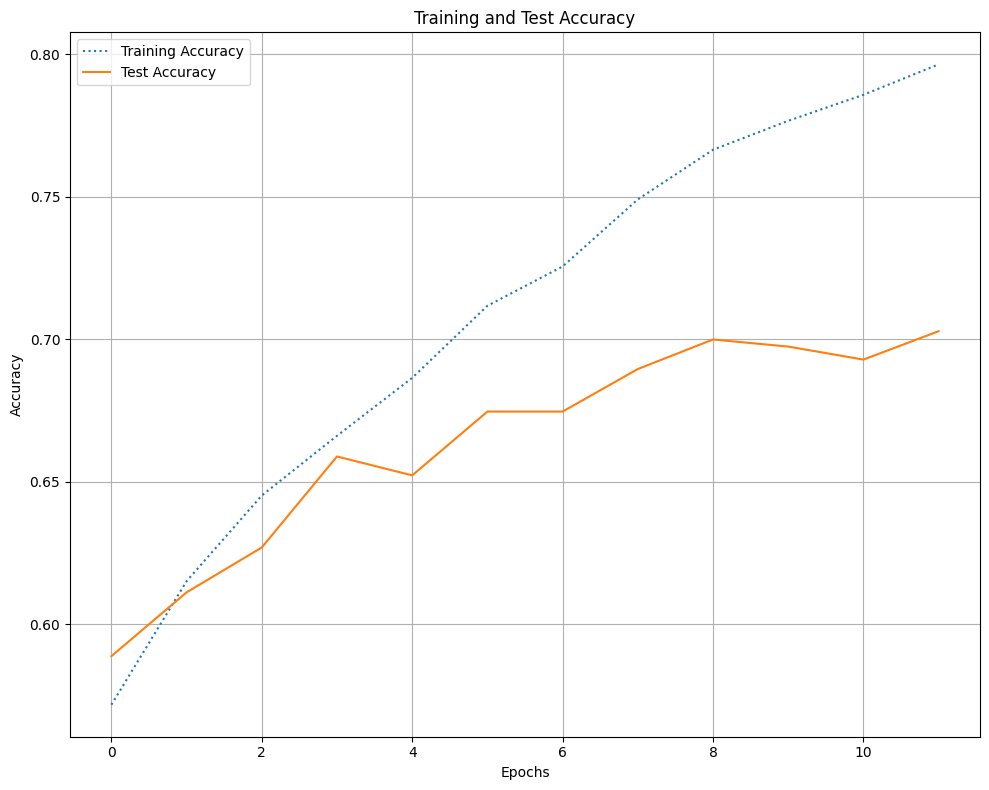

In [25]:
fig, (ax1) = plt.subplots(1,  1, figsize=(10, 8)) 

# Plot Training and Test Accuracy
ax1.plot(train_accuracy_list, label='Training Accuracy', linestyle=':')
ax1.plot(test_accuracy_list, label='Test Accuracy')
ax1.set_title('Training and Test Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.grid(True)
ax1.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


7.As you've astutely observed, we're facing a significant challenge in enumerating all possible combinations of widths and depths and searching over them. Given the circumstances, could you explore and implement a more efficient method for searching through these combinations that could significantly reduce the computational time but achieve similar search results?

In [28]:
random_combinations = random.sample(num_neurons, int(0.3 * len(num_neurons)))
print(f"New Random Sample of the network combinations: {random_combinations})")

cross_validation_accuracies2, cross_validation_times2 =find_optimal_hyperparameter(X_train.to_numpy(), y_train, random_combinations, 'num_neurons', optimal_bs)

New Random Sample of the network combinations: [(128, 256, 128), (64, 256, 128), (256, 256, 64), (128, 64, 64), (64, 128, 128), (256, 256, 256), (128, 128, 64), (256, 128), (128, 256), (64, 128, 64), (64, 64, 128)])
--------------------- num_neurons: (128, 256, 128) ---------------------
------ Fold: 1 ------
Epoch 1: Train_accuracy: 55.22%, Train_loss: 0.685535, Val_accuracy: 55.57%, val_loss: 0.680469
Epoch 2: Train_accuracy: 59.27%, Train_loss: 0.667556, Val_accuracy: 60.03%, val_loss: 0.656716
Epoch 3: Train_accuracy: 62.43%, Train_loss: 0.648101, Val_accuracy: 61.85%, val_loss: 0.648606
Epoch 4: Train_accuracy: 64.58%, Train_loss: 0.629520, Val_accuracy: 61.53%, val_loss: 0.641641
Epoch 5: Train_accuracy: 67.76%, Train_loss: 0.604977, Val_accuracy: 64.07%, val_loss: 0.626525
Epoch 6: Train_accuracy: 68.49%, Train_loss: 0.582838, Val_accuracy: 65.94%, val_loss: 0.615824
Epoch 7: Train_accuracy: 70.31%, Train_loss: 0.563557, Val_accuracy: 65.27%, val_loss: 0.619206
Epoch 8: Train_ac

In [29]:
cross_validation_accuracies2 = {str(key): value for key, value in cross_validation_accuracies2.items()}
cross_validation_times2 = {str(key): value for key, value in cross_validation_times2.items()}

C:\Users\joann\AppData\Local\Temp\ipykernel_30344\278527688.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(sorted_accuracies2.keys(), rotation=90)
C:\Users\joann\AppData\Local\Temp\ipykernel_30344\278527688.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(sorted_time2.keys(), rotation=90)


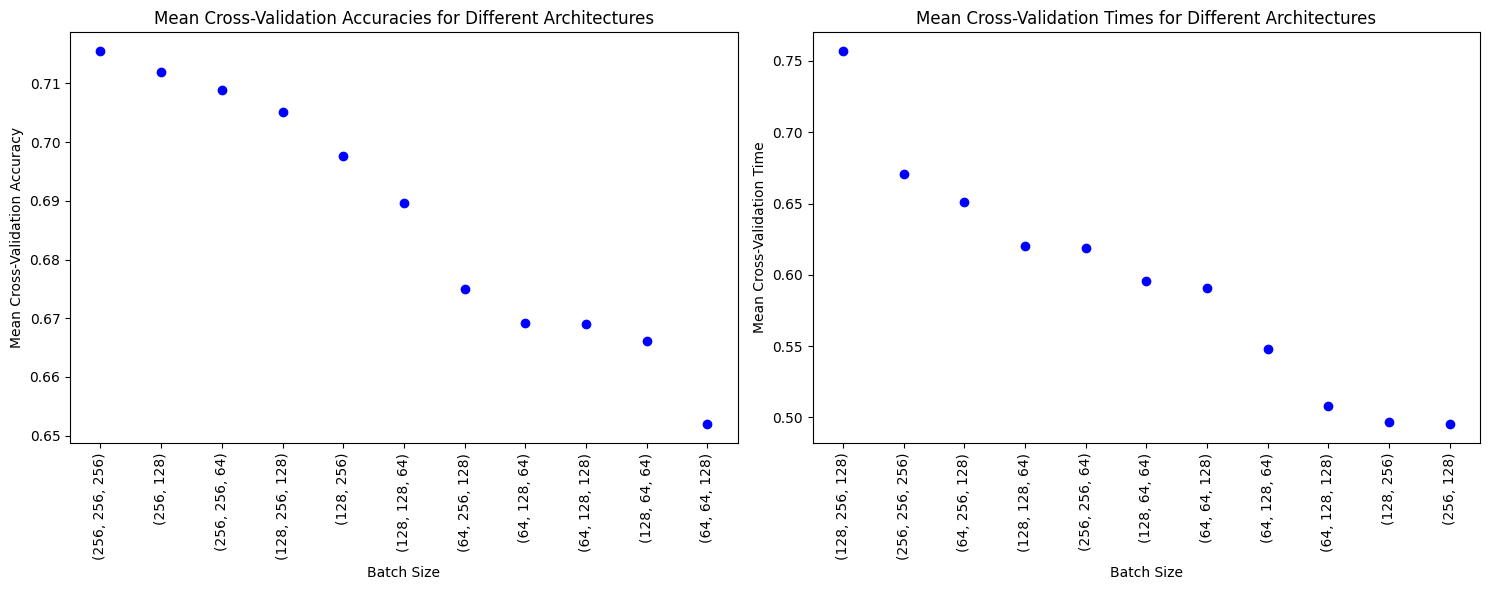

In [30]:
# Plotting the graphs side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot the mean cross-validation accuracy 
sorted_accuracies2 = dict(sorted(cross_validation_accuracies2.items(), key=lambda item: item[1], reverse=True))
axs[0].scatter(sorted_accuracies2.keys(), sorted_accuracies2.values(), color='blue')
axs[0].set_title('Mean Cross-Validation Accuracies for Different Architectures')
axs[0].set_xlabel('Batch Size')
axs[0].set_xticklabels(sorted_accuracies2.keys(), rotation=90)
axs[0].set_ylabel('Mean Cross-Validation Accuracy')

# Plot the mean cross-validation time 
sorted_time2 = dict(sorted(cross_validation_times2.items(), key=lambda item: item[1], reverse=True))
axs[1].scatter(sorted_time2.keys(), sorted_time2.values(), color='blue')
axs[1].set_xticklabels(sorted_time2.keys(), rotation=90)
axs[1].set_title('Mean Cross-Validation Times for Different Architectures')
axs[1].set_xlabel('Batch Size')
axs[1].set_ylabel('Mean Cross-Validation Time')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Random Grid Search vs Full Search

### Search Time Comparison

- **Time to perform a full grid search**: 
  - 42 minutes 10.5 seconds
  
- **Time to perform 30% of all possible combinations (Random Grid Search)**: 
  - 8 minutes 10.6 seconds

- **Time reduction**: 
  - ~80% (by using random sampling)

### Accuracy Results

- **Best accuracy from Random Grid Search**: 
  - 71.6% (found using a configuration of layers [128, 256, 128])
  
- **Optimal accuracy from Full Grid Search**: 
  - 72% (achieved with a configuration of layers [256, 256])

There is a decrease in 0.4% accuracy

### Interpretation of Results

- **Random grid search**: 
  - It achieved a relatively good accuracy (71.6%) in significantly less time compared to full grid search.
  
  - **Time saved**: The 80% reduction in computational time demonstrates that random grid search can be an effective method for finding a near-optimal solution quickly.
  
  - **Risk**: Since random grid search samples configurations randomly, there's a chance it might select the least-performing configurations. In the worst case, the highest accuracy achieved could be as low as 67%. 

### Trade-off: Accuracy vs. Computation Time

- Increasing the number of samples for random grid search can improve the chances of finding a more optimal solution, but this comes at the cost of additional computational time.

